House Price Predictions - Regresion

Modules

In [1]:
# Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression
import xgboost
from sklearn.preprocessing import StandardScaler, RobustScaler

# Configuration
import warnings
warnings.filterwarnings("ignore")

#Seed
import random
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

Data Manipulation

In [2]:
data = pd.read_csv('../Data/train.csv', sep = ';')
data.drop(columns='Id', inplace=True)
data.shape

(1460, 80)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

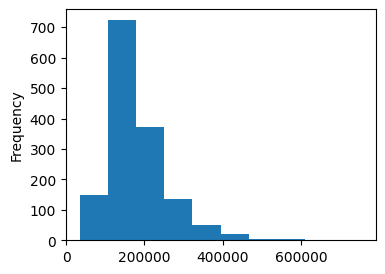

In [3]:
# Target
data.SalePrice.plot.hist(figsize = (4,3))
data.SalePrice.describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

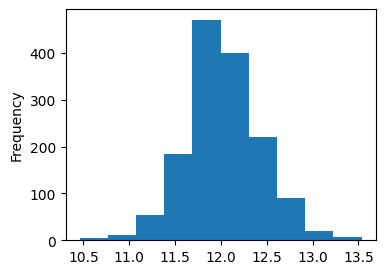

In [4]:
data.SalePrice = np.log(data.SalePrice)
data.SalePrice.plot.hist(figsize = (4,3))
data.SalePrice.describe()

Missing values

In [5]:
data.isna().sum().sort_values(ascending=False)[:13]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
dtype: int64

In [6]:
quality = {'Ex':5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1, 'No': 0}
#yes_no = {'No':0,'Yes': 1}

# Pool1QC
data.PoolQC[~data.PoolQC.isna()] = 'Yes'
data.PoolQC.fillna('No', inplace=True)
#data.groupby('PoolQC')['SalePrice'].mean()

# MiscFeature
data.MiscFeature[~data.MiscFeature.isna()] = 'Yes'
data.MiscFeature.fillna('No', inplace=True)
#data.groupby('MiscFeature')['SalePrice'].mean()

# Alley
data.Alley[data.Alley.isna()] = 'No alley access'
#data.groupby('Alley')['SalePrice'].mean()

# Fence
data.Fence[~data.Fence.isna()] = 'Yes'
data.Fence.fillna('No', inplace=True)
#data.groupby('Fence')['SalePrice'].mean()

# MasVnrType
data.MasVnrType.fillna('Not Reported', inplace=True)
#data.groupby('MasVnrType')['SalePrice'].mean()

# FireplaceQu
#data.FireplaceQu[~data.FireplaceQu.isna()] = 'Yes'
data.FireplaceQu.fillna('No', inplace=True)
#data.FireplaceQu = data.FireplaceQu.map(quality)
#data.groupby('FireplaceQu')['SalePrice'].mean()

# LotFrontage
lotshape_medians = data.groupby("LotShape")["LotFrontage"].median()
data["LotFrontage"] = data["LotFrontage"].fillna(data["LotShape"].map(lotshape_medians))

# GarageQual
data.GarageQual.fillna('No', inplace=True)
#data.GarageQual = data.GarageQual.map(quality)
#data.groupby('GarageQual')['SalePrice'].mean()

Data Manipulation

New Features

In [7]:
# Building Age
data['BuildingAge'] = data.YearBuilt.max() - data.YearBuilt + 1
data['Remodeling'] = (data['YearBuilt'] != data['YearRemodAdd'])

# Garage Age
data['GarageYrBlt'] = data.GarageYrBlt.max() - data.GarageYrBlt + 1

# Drop unecessary cols
data.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt'], inplace=True)

Engineering

In [8]:
# Binary cols
binary_cols = data.apply(lambda x: pd.Series(x).nunique() == 2, axis = 0)
print(f'Number of binary cols: {binary_cols.sum()}')
binary_cols = binary_cols[binary_cols].index.tolist()
print(binary_cols)

for col in binary_cols:
    dict_col = {data[col].unique()[0]:0, data[col].unique()[1]:1}
    data[col] = data[col].map(dict_col).astype('boolean')
    
# Specific cols
data.MSSubClass = data.MSSubClass.astype('O')
data.YrSold = data.YrSold.astype('O')
data.MoSold = data.MoSold.astype('O')

# Quality related cols
mask = data.columns.str.contains(r'Qu', regex=True)
cols_to_map = data.loc[:, mask].columns.difference(['OverallQual','LowQualFinSF'])
data[cols_to_map] = data[cols_to_map].apply(lambda x: x.map(quality), axis=1)

Number of binary cols: 7
['Street', 'Utilities', 'CentralAir', 'PoolQC', 'Fence', 'MiscFeature', 'Remodeling']


Outliers

In [9]:
# Keep only numeric features
number_cols = data.drop(columns='SalePrice').select_dtypes(include='number')
# Give the same scale across all of them
stnd = StandardScaler()
number_cols = pd.DataFrame(stnd.fit_transform(number_cols), columns=number_cols.columns)
# Compute mean values per row
mn = number_cols.apply(lambda x: x.mean(), axis = 1)
# Remove rows extreme rows
outliers = mn.index[(mn > (mn.mean() + 4*mn.std())) | (mn < (mn.mean() - 4*mn.std()))]
# Remove outliers
data.drop(index=outliers, inplace=True)

Feature selction

In [44]:
output = {
    'Feature': []
    ,'RMSE': []
    ,'R2': []
    ,
    }
for col in data.drop(columns='SalePrice').columns:
    d = data[[col, 'SalePrice']].dropna()
    Xtrain, Xtest, ytrain, ytest = train_test_split(d[[col]], d.SalePrice, test_size=0.2, random_state=999)

    if not pd.api.types.is_numeric_dtype(Xtrain[col]):
        Xtrain = pd.get_dummies(Xtrain, drop_first=True)
        Xtest = pd.get_dummies(Xtest, drop_first=True)
        Xtest = Xtest.reindex(columns=Xtrain.columns, fill_value=0)

    # Model
    lr = LinearRegression()
    lr_model = lr.fit(Xtrain, ytrain)
    pred = lr_model.predict(Xtest)

    # Output
    output['Feature'].append(col)
    output['RMSE'].append(root_mean_squared_error(ytest, pred))
    output['R2'].append(r2_score(ytest, pred))

output = pd.DataFrame(output).sort_values(by = 'RMSE', ascending=True).reset_index(drop=True)

In [45]:
output.iloc[0:10,:]

,Feature,RMSE,R2
0,OverallQual,0.211776,0.679630
1,Neighborhood,0.258545,0.522506
2,ExterQual,0.262166,0.509037
3,TotalBsmtSF,0.267094,0.490407
4,BsmtQual,0.270610,0.464954
5,GarageCars,0.273190,0.466879
6,KitchenQual,0.274580,0.461439
7,GrLivArea,0.281574,0.433654
8,GarageArea,0.282253,0.430921
9,GarageFinish,0.292744,0.319687


Visualizations

In [32]:
report_features = output.iloc[0:4, :].Feature
report_features

16     OverallQual
11    Neighborhood
24       ExterQual
35     TotalBsmtSF
Name: Feature, dtype: object

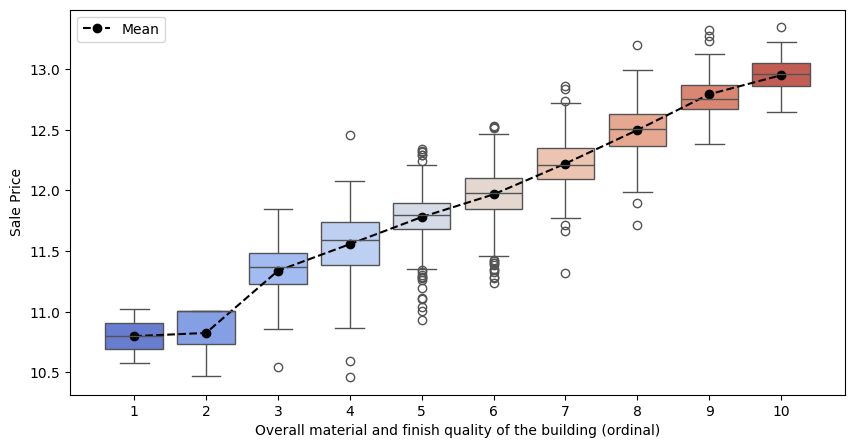

In [ ]:
# Overall Quality
plt.figure(figsize=(10,5))

sns.boxplot(x='OverallQual', y='SalePrice', data=data, palette='coolwarm')
mean_prices = data.groupby('OverallQual')['SalePrice'].mean()
# Add meanline
plt.plot(np.arange(len(mean_prices)), mean_prices, color='black', marker='o', linestyle='--', label='Mean')

plt.xlabel('Overall material and finish quality of the building (ordinal)')
plt.ylabel('Log - Sale Price ($)')
plt.legend()
plt.show()

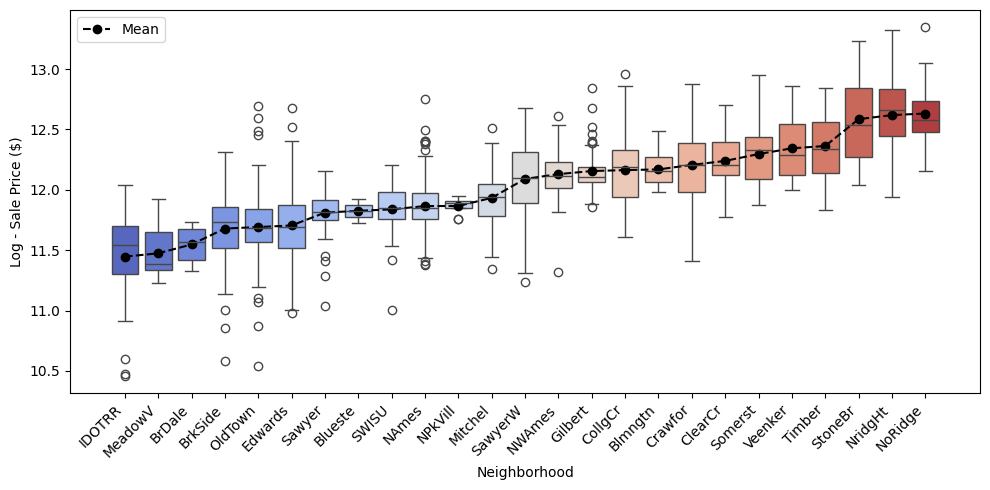

In [78]:
mean_prices = data.groupby('Neighborhood')['SalePrice'].mean().sort_values()
data['Neighborhood'] = pd.Categorical(data['Neighborhood'], categories=mean_prices.index, ordered=True)

plt.figure(figsize=(10,5))
sns.boxplot(x='Neighborhood', y='SalePrice', data=data, palette='coolwarm')
sns.stripplot(x='Neighborhood', y='SalePrice', data=data, color='None', alpha=0.3, jitter=0.2, size=3)
plt.plot(np.arange(len(mean_prices)), mean_prices.values, color='black', marker='o', linestyle='--', label='Mean')
plt.xlabel('Neighborhood')
plt.ylabel('Log - Sale Price ($)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

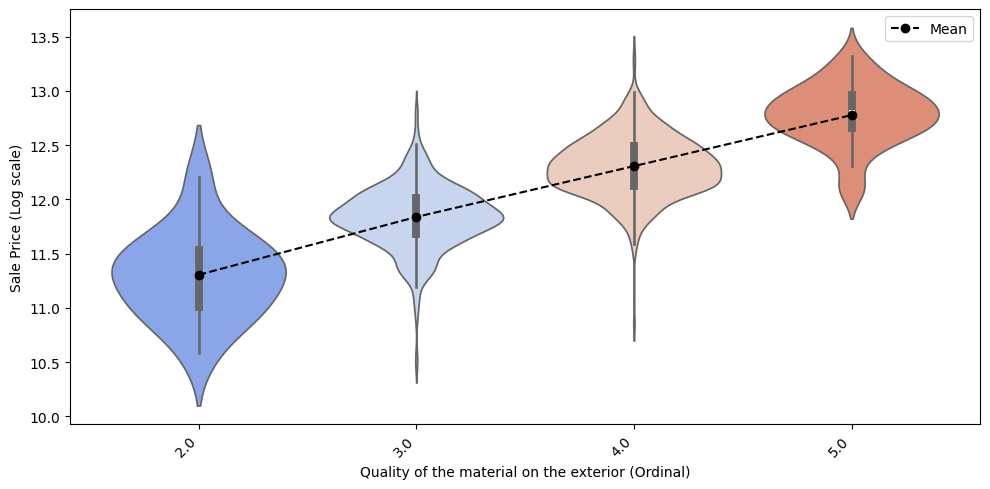

In [ ]:
mean_prices = data.groupby('ExterQual')['SalePrice'].mean().sort_values()
data['ExterQual'] = pd.Categorical(data['ExterQual'], categories=mean_prices.index, ordered=True)

plt.figure(figsize=(10,5))

sns.violinplot(x='ExterQual', y='SalePrice', data=data, palette='coolwarm', scale='width')

plt.plot(np.arange(len(mean_prices)), mean_prices.values, color='black', marker='o', linestyle='--', label='Mean')
plt.xlabel('Quality of the material on the exterior of the building (Ordinal)')
plt.ylabel('Sale Price (Log scale)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


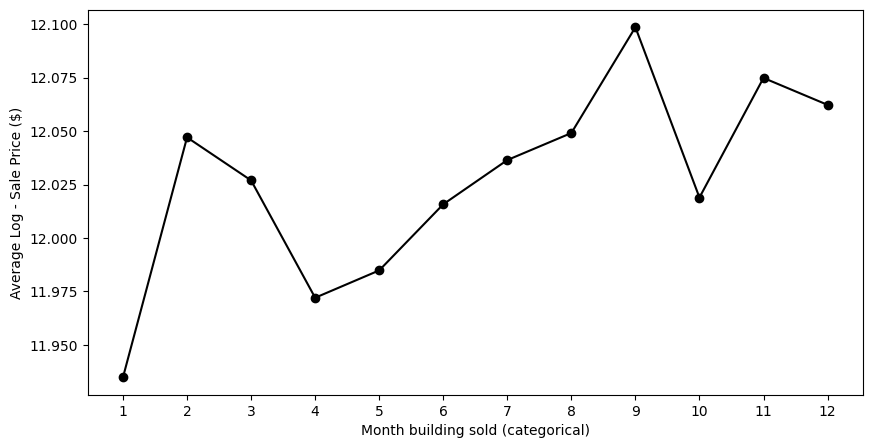

In [77]:
monthly_mean = data.groupby('MoSold')['SalePrice'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly_mean['MoSold'], monthly_mean['SalePrice'], marker='o', linestyle='-', color='black')

plt.xlabel('Month building sold (categorical)')
plt.ylabel('Average Log - Sale Price ($)')
plt.xticks(range(1,13))
plt.grid(False) 
plt.show()

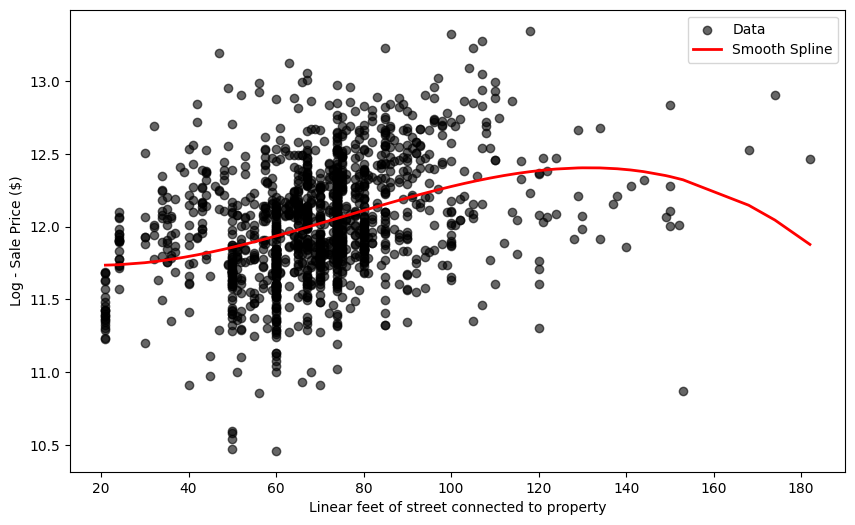

In [76]:
from scipy.interpolate import UnivariateSpline
d = data[data.LotFrontage < 300]
# Data
x = d['LotFrontage'].values
y = d['SalePrice'].values

# Sort data for spline
sorted_idx = np.argsort(x)
x_sorted = x[sorted_idx]
y_sorted = y[sorted_idx]

# Fit spline
spline = UnivariateSpline(x_sorted, y_sorted, s=1e8)  # s controls smoothness
y_smooth = spline(x_sorted)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.6, color='black', label='Data')
plt.plot(x_sorted, y_smooth, color='red', linewidth=2, label='Smooth Spline')

plt.xlabel('Linear feet of street connected to property')
plt.ylabel('Log - Sale Price ($)')
plt.legend()
plt.show()


In [71]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BuildingAge,Remodeling
0,60,RL,65.0,8450,False,No alley access,Reg,Lvl,False,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,TA,PConc,4.0,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,False,SBrkr,856,854,0,1710,1,0,2,1,3,1,4.0,8,Typ,0,0.0,Attchd,RFn,2,548,3.0,TA,Y,0,61,0,0,0,0,False,False,False,0,2,2008,WD,Normal,12.247694,8,False
1,20,RL,80.0,9600,False,No alley access,Reg,Lvl,False,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,Not Reported,0.0,3.0,TA,CBlock,4.0,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,False,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3.0,6,Typ,1,3.0,Attchd,RFn,2,460,3.0,TA,Y,298,0,0,0,0,0,False,False,False,0,5,2007,WD,Normal,12.109011,35,False
2,60,RL,68.0,11250,False,No alley access,IR1,Lvl,False,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,TA,PConc,4.0,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,False,SBrkr,920,866,0,1786,1,0,2,1,3,1,4.0,6,Typ,1,3.0,Attchd,RFn,2,608,3.0,TA,Y,0,42,0,0,0,0,False,False,False,0,9,2008,WD,Normal,12.317167,10,True
3,70,RL,60.0,9550,False,No alley access,IR1,Lvl,False,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,Not Reported,0.0,3.0,TA,BrkTil,3.0,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,False,SBrkr,961,756,0,1717,1,0,1,0,3,1,4.0,7,Typ,1,4.0,Detchd,Unf,3,642,3.0,TA,Y,0,35,272,0,0,0,False,False,False,0,2,2006,WD,Abnorml,11.849398,96,True
4,60,RL,84.0,14260,False,No alley access,IR1,Lvl,False,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,TA,PConc,4.0,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,False,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4.0,9,Typ,1,3.0,Attchd,RFn,3,836,3.0,TA,Y,192,84,0,0,0,0,False,False,False,0,12,2008,WD,Normal,12.429216,11,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,False,No alley access,Reg,Lvl,False,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,Not Reported,0.0,3.0,TA,PConc,4.0,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,False,SBrkr,953,694,0,1647,0,0,2,1,3,1,3.0,7,Typ,1,3.0,Attchd,RFn,2,460,3.0,TA,Y,0,40,0,0,0,0,False,False,False,0,8,2007,WD,Normal,12.072541,12,True
1456,20,RL,85.0,13175,False,No alley access,Reg,Lvl,False,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,3.0,TA,CBlock,4.0,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,False,SBrkr,2073,0,0,2073,1,0,2,0,3,1,3.0,7,Min1,2,3.0,Attchd,Unf,2,500,3.0,TA,Y,349,0,0,0,0,0,False,True,False,0,2,2010,WD,Normal,12.254863,33,True
1457,70,RL,66.0,9042,False,No alley access,Reg,Lvl,False,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,Not Reported,0.0,5.0,Gd,Stone,3.0,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,False,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,4.0,9,Typ,2,4.0,Attchd,RFn,1,252,3.0,TA,Y,0,60,0,0,0,0,False,True,True,2500,5,2010,WD,Normal,12.493130,70,True
1458,20,RL,68.0,9717,False,No alley access,